# Module 2 Lab 1 - Kaplan-Meier Plots, Survival Analysis, and Hazard Ratios

In this lab we will use a sample dataset to calculate the hazard ratio for a study of a drug to treat leukemia.  This study was a matched pairs study, with one of the pairs a control and the other in the treatment group.  Both subjects for each pair were withdrawn from the study when one of the pair relapsed.

The Hazard Ratio concerns itself with the rate at which an event of interest happens.  In this case, relapse of disease.  The Hazard Ratio is simply the treatment hazard rate/placebo hazard rate.  However, the rate at which the events occur is also important, otherwise this would be a measure of relative risk.  The hazard ratio supplies the risk of the event at any point in time, whereas relative risk is a measurement of the risk at the end of the study.

During our analysis, we will create a Kaplan-Meier plot to visualize the hazard between the groups, and calculate the Harzard Ratio using the Cox Proportional Hazards model.

Documentation for the leukemia dataset is [here](../resources/leukaemia.html)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
!{sys.executable} -m pip install lifelines


     |████████████████████████████████| 358kB 3.4MB/s eta 0:00:01
     |████████████████████████████████| 61kB 6.4MB/s  eta 0:00:01
     |████████████████████████████████| 81kB 13.2MB/s eta 0:00:01
     |████████████████████████████████| 829kB 11.6MB/s eta 0:00:01
  Created wheel for autograd: filename=autograd-1.3-cp37-none-any.whl size=47990 sha256=6a21aa36fbba55a9b54c1ae79ed5d02093b22fd7875ae031d17259760d8d5eb4
  Stored in directory: /home/dcphw2/.cache/pip/wheels/42/62/66/1121afe23ff96af4e452e0d15e68761e3f605952ee075ca99f
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-cp37-none-any.whl size=4034 sha256=245207e54c54cc21467a74611b3ff30b2cb86d73bfadf15c91c68817058d92d4
  Stored in directory: /home/dcphw2/.cache/pip/wheels/dc/68/dc/91321c55fba449755524481854f5be70d41912b8f886f908bb
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491057 sha256=4c2f16c8ed5443fc1e53630f8f130f1ce0edd488e92ecc0854c72e9c93ee45b5
  Stored in directory: /home/dcphw2

In [2]:
data = pd.read_csv('../resources/leukaemia.csv', index_col=0)

# create a binary numeric variable for the treatment group
# 0 = treatment
# 1 = control
data['treat'] = data['treat'].apply(lambda x: 1 if x == 'control' else 0)


data.head()

,pair,time,cens,treat
1,1,1,1,1
2,1,10,1,0
3,2,22,1,1
4,2,7,1,0
5,3,3,1,1


## Kaplan-Meier fitting

We will explore event tables and the Kaplan-Meier plot and estimator on our dataset.  

## Assumptions
The assumptions that must be met for this analysis to be valid are:
1. Censoring is unrelated to the outcome.
1. The survival probabilities are the same for subjects recruited early and late in the study.
1. The events happened at the recorded times.

In [3]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()


## Marking the event as having occurred or not
We need a column to mark the event as having occurred or not occurred.  This, along with the time the event occured, is what allows us to make a Kaplan-Meier plot, generate event tables, and ultimately calculate a Hazard Ratio. The `cens` column tells us if the event is censored for that subject or not.

## Censoring
As we work through Hazard Ratios and Survival Analysis, the term censoring will be important to understand.  Censored data means that the outcome or event being measured was not measured during the course of the study.  There are three types of censoring:

1. right censored - The event did not occur before the end of the study, so the exact time of the event is unknown.
1. left-censored - The event occured before the start of the study, so the exact time of the event is unknown.
1. interval-censored - The event occured during some timeframe, but the exact time is unknown.  This can happen if data are collected every so many hours or days on subjects, and the event is noted to have occured, but the exact time of occurrence during the interval is not known.

Right censored data is common in medical studies and randomized controlled trials.  The outcome of measurement is usually onset of disease, relapse of disease, contraction of disease, or death.  Study subjects can be lost to followup, or do not have the event before the study ends, resulting in right censored data.

In the data we are using, the `cens` column tells us if the data are right censored (`cens = 0`, event did not occur during the study) or not (`cens = 1`, event occured during the study)

## Time
In Survival analysis, time is not represented as an absolute value, such as a date on a calendar.  Rather, it is represented as a relative time.  The point from which the time is relative can differ, as can the units of time in different datasets; however, within a dataset, these things must be consistent before we can undertake a survival analysis.  Points from which to measure relative time can be from birth, from the start of a study, exposure to a treatment or disease, or from the first dose of a trial drug, for example.  Time can be measured in minutes, hours, days, weeks, years, etc.  It is important for the relative beginning time point to be applied consistently, and for the time measurements to use consistent units.



In [4]:
kmf.fit(durations = data['time'], event_observed = data['cens'])

event_table = kmf.event_table

display(event_table)

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,42,42
1.0,2,2,0,0,42
2.0,2,2,0,0,40
3.0,1,1,0,0,38
4.0,2,2,0,0,37
5.0,2,2,0,0,35
6.0,4,3,1,0,33
7.0,1,1,0,0,29
8.0,4,4,0,0,28


## The event table
The event table gives us a row for each time point measured in the study.  At event time 0, every subject in the study has not had the event.  The at_risk column tells us how may subjects are at risk of having the event.  This column will dimish over each row as subjects have the event.  The first row, where `event_at == 0`, `at_risk` is the total number of subjects.  In the following rows, it will show the number of subjects that have not had the event at the beginning of the time period.  The column `observed` counts the number of subjects observed having the event, and `censored` tells us how many subjects left the study at that point without having the event.  `removed` is the sum of observed and censored.

## Probabilities of survival at specific times
We can calulate the probability of the event happening (survival) at a specific time point using the formula: $S=\frac {at\_risk - observed} {at\_risk}$

In [5]:
event_table['S'] = (event_table['at_risk'] - event_table['observed']) / event_table['at_risk']

event_table

,removed,observed,censored,entrance,at_risk,S
event_at,,,,,,
0.0,0,0,0,42,42,1.000000
1.0,2,2,0,0,42,0.952381
2.0,2,2,0,0,40,0.950000
3.0,1,1,0,0,38,0.973684
4.0,2,2,0,0,37,0.945946
5.0,2,2,0,0,35,0.942857
6.0,4,3,1,0,33,0.909091
7.0,1,1,0,0,29,0.965517
8.0,4,4,0,0,28,0.857143


## Cumulative probability of survival
This is interesting, but what we really want to know is the _cumulative_ probability of survival at a time point, which is the multiplicative of all prior probabilities.  I.e. the cumulative probability of surviving to time point 3 is 1 * 0.952381 * 0.95 * 0.973684 = 0.881.  To get cumulative probabilities for every time point in the event table, we need to apply this at each row.

Fortunately, `lifelines` will do this for us.

In [6]:
# survival probability for a specific time point
print(kmf.predict(3))

0.8809523809523808


In [7]:
# survival probability for a list of time points
print(kmf.predict([1,2,3,4,5]))

1    0.952381
2    0.904762
3    0.880952
4    0.833333
5    0.785714
Name: KM_estimate, dtype: float64


In [8]:
# survival probability for all time points, appended to event_table
event_table['cumulative_S'] = kmf.survival_function_

event_table

,removed,observed,censored,entrance,at_risk,S,cumulative_S
event_at,,,,,,,
0.0,0,0,0,42,42,1.000000,1.000000
1.0,2,2,0,0,42,0.952381,0.952381
2.0,2,2,0,0,40,0.950000,0.904762
3.0,1,1,0,0,38,0.973684,0.880952
4.0,2,2,0,0,37,0.945946,0.833333
5.0,2,2,0,0,35,0.942857,0.785714
6.0,4,3,1,0,33,0.909091,0.714286
7.0,1,1,0,0,29,0.965517,0.689655
8.0,4,4,0,0,28,0.857143,0.591133


We can see that the probability of survival at 35 weeks is about 19%.

## Plotting the Kaplan-Meier curve
This is the well known plot that allows you see at a glance the survival probability over time.
Remember that we are using the term survival here to mean an event that has occurred.  In our example it is a relapse of leukemia.  It can literally mean death as well or any other event such as giving birth.  

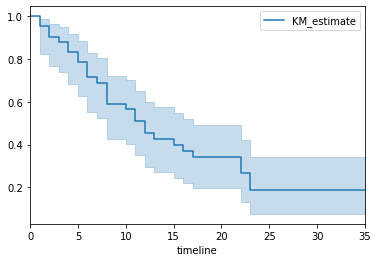

In [9]:
kmf.plot()

## Kaplan-Meier for grouped data
We've seen the plot for all of our data, but recall that this data has two study arms: a control and a drug.  We can use Kaplan-Meier to see if there is a difference in survival between these groups.  To do this, we will simply reproduce the above steps but with two separate fitters and data sets split by the study arm.

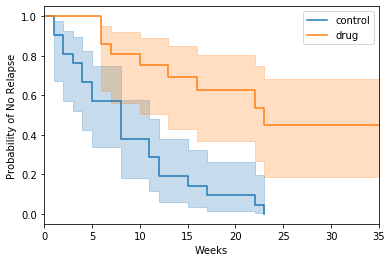

In [10]:
kmf_control = KaplanMeierFitter()
kmf_drug = KaplanMeierFitter()

data_control = data[data['treat'] == 1]
data_drug = data[data['treat'] == 0]

kmf_control.fit(durations = data_control['time'], event_observed = data_control['cens'], label='control')
kmf_drug.fit(durations = data_drug['time'], event_observed = data_drug['cens'], label='drug')

kmf_control.plot()
kmf_drug.plot()

_ = plt.xlabel('Weeks')
_ = plt.ylabel('Probability of No Relapse')

## Interpretation
Based on this chart, it is reasonable to assume that the drug has an effect on the length of relapse into leukemia, and would warrant further investigation.

## The Log-Rank hypothesis test
We can apply the log-rank test to test the null hypothesis that there is no difference in the survival distribution between two groups.  The assumptions for this test are the same as for the Kaplan-Meier curve.


In [11]:
from lifelines.statistics import logrank_test

results = logrank_test(data_control['time'], data_drug['time'], event_observed_A=data_control['cens'], event_observed_B=data_drug['cens'])

results.print_summary()
print(results.p_value)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          16.79 <0.005     14.55

4.1688091093345355e-05


## Interpretation
The results give us a p value which we can use to compare to our alpha.  In this case, the p values is very small so we reject the null that the survival distributions are equal.

## Cox Proportional Hazard model
The Cox Proportional Hazard model will apply a regression to the data that we have and give us a hazard ratio.

The Hazard Ratio is bounded by zero on the lower and unbounded on the upper, and interpreted as follows:

  * hazard ratio of 1: rate of the event is equal between the groups
  * hazard ratio != 1: this many patients in the treatment group will have the event for every patient having the event in the control group

For example, if the hazard ratio is 2, then twice as many treatment group patients will have the event as the control group in the next unit of time.  If the ratio is 0.5, then half as many treatment group patients will have the event as the control group in the next unit of time.

In this class we will apply the Cox Proportional Hazard Model implemented in the lifelines package, which is applicable to right-censored data.

https://github.com/CamDavidsonPilon/lifelines


In [12]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()


In [13]:
display(data.head())

# Provide only the data that you wish to be used in the regression.  
# All columns other than the duration_col and the event_col will be used as covariates
cph.fit(data[['time', 'cens', 'treat']], duration_col='time', event_col='cens')

cph.print_summary() 

,pair,time,cens,treat
1,1,1,1,1
2,1,10,1,0
3,2,22,1,1
4,2,7,1,0
5,3,3,1,1


<lifelines.CoxPHFitter: fitted with 42 total observations, 12 right-censored observations>
             duration col = 'time'
                event col = 'cens'
      baseline estimation = breslow
   number of observations = 42
number of events observed = 30
   partial log-likelihood = -85.01
         time fit was run = 2022-01-24 20:19:03 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
treat       1.57       4.82       0.41             0.76             2.38                 2.15                10.81

             z      p   -log2(p)
covariate                       
treat     3.81 <0.005      12.83
---
Concordance = 0.69
Partial AIC = 172.02
log-likelihood ratio test = 16.35 on 1 df
-log2(p) of ll-ratio test = 14.21

## Interpretation

In our analysis, we find the Hazard Ratio from the output of the coefficients.  The column labeled `exp(coef)` is the Hazard Ratio.  The coefficients of the model represent the log of the Hazard Ratio for that independent variable.

We can check the p value (`p` in the table) for each independent variable in the model for significance.  The p value for `treat` is small so this variable is a good candidate for comparing our data, which comes as no surprise since the log rank test on the data split by `treat` confirmed a significant difference in survival.

The sign of the coefficients (`coef` from the output table) can be interpreted as:
    * positive coefficient - the risk of the event is higher in the second group relative to the first
    * negative coefficient - the risk of the event is lower in the second group relative to the first
    
The hazard ratio reported here is dependent on the numeric value assigned to the groups.  The results of the hazard ratio are for the second group relative to the first (by ordinal position of the group number).  Using the sign of the coefficient tells us if the hazard is higher or lower.

Our hazard ratio indicates that patients in the control group (value = 1) increases the hazard of a relapse of leukemia by a factor of 4.8 as compared to patients taking the drug under study (value = 0).